# Comparing different Input Dropout and Replacement strategies for CollaGAN

 This notebook compares the input dropout strategies of no dropout, the original version, a curriculum learning approach and a conservative tactic.
 
In addition, it compares two replacement strategies during the backward step of the training procedure: to substitute the original target and all dropped out images by the one generated in the forward pass (replacer-dropout) and to substitute only the original target leaving the initially dropped out images as zeros. 

In [1]:
import gc
import logging
from time import time

import logging_utils

from ModelProxy import CollaGANModelProxy

logging_utils.configure()

# for the input dropout test, we need the models:
# replacer-forward, no dropout
# replacer-forward, original 18:30 29-05
# replacer-forward, conservative
#
# for the replacer test, we need the models:
# replacer-dropout, conservative 19:30 30-05
# replacer-forward, conservative
#
dropout_model_loaders = {
    'No Dropout': lambda: CollaGANModelProxy('models/selection/collagan/replacer-forward-240k/input-dropout-no'),
    'Original': lambda: CollaGANModelProxy(
        'models/selection/collagan/replacer-forward-240k/input-dropout-original'),
    'Conservative': lambda: CollaGANModelProxy(
        'models/selection/collagan/replacer-forward-240k/input-dropout-conservative'),
}

replacer_model_loaders = {
    'Target + Dropped Out': lambda: CollaGANModelProxy(
        'models/selection/collagan/collagan-rmxp/replacer-dropout-40k/input-dropout-conservative'),
    'Target Only': lambda: CollaGANModelProxy(
        'models/selection/collagan/collagan-rmxp/replacer-forward-40k/input-dropout-conservative'),
}

## Loads the Larger Dataset

These tests use the Larger dataset.


In [2]:
from dataset_utils import DatasetLoader


dataset_loader = DatasetLoader("all", "test", limit=None)
starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}

## Input Dropout Image Comparison 

In [3]:
import tensorflow as tf

def generate_batch_with_each_model(loaders, number_of_samples=1,
                                   # target_index=2, 
                                   # keep_mask=[[1, 1, 0, 1], [1, 0, 0, 1], [0, 0, 0, 1]],
                                   target_index=1, 
                                   keep_mask=[[1, 0, 1, 1], [1, 0, 0, 1], [1, 0, 0, 0]],
                                   sample_numbers=None):
    source_dropout_situations = 3   # can miss 1, 2 or 3 images
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    batch_transpose = None
    if mode == "specific_samples":
        batch = [dataset_loader.load_paired_images(tf.constant(sample_number, dtype=tf.int32)) for sample_number in sample_numbers]
        batch = tf.stack(batch, axis=0)
        batch = tf.repeat(batch, source_dropout_situations, axis=0)
        batch_transpose = batch
        number_of_samples = len(sample_numbers)
    elif mode == "random_batch":
        # loads a batch of images
        batch = next(iter(dataset_loader.dataset.shuffle(600).batch(number_of_samples).take(1)))
        batch = tf.repeat(batch, source_dropout_situations, axis=0)
        batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])
    
    genned_images = []
    target_indices = tf.repeat(target_index, [number_of_samples * 3])
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    keep_mask = tf.tile(tf.constant(keep_mask, dtype=tf.float32), [number_of_samples, 1])
    source_images = batch_transpose * keep_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
    model_names = list(loaders.keys())
    for model_name, model_loader in loaders.items():
        # loads the model into memory
        generator = model_loader()    
        # generates the images
        fake_images = generator.generate_from_multiple(target_indices, source_images)
        genned_images += [fake_images]
        # frees the memory used by the model
        del generator

    return source_images, target_images, genned_images, "", model_names, target_indices


example_numbers=[
    # stsn["rmxp"]+32,    # rmxp monk
    # stsn["rmxp"]+33,    # rmxp monk
    # stsn["rmxp"]+34,    # rmxp monk
    # stsn["rmxp"]+25,    # rmxp maid lady
    # stsn["misc"]+779,   # misc suitman                
    # stsn["rmxp"]+4,     # rmxp bunny tiara girl 
    # stsn["misc"]+1701,  # misc tiny butt
    # stsn["rmxp"]+5,     # rmxp cook
    # stsn["rmvx"]+27,    # rmvx santa
    stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]
imgs_params = generate_batch_with_each_model(dropout_model_loaders, sample_numbers=example_numbers)


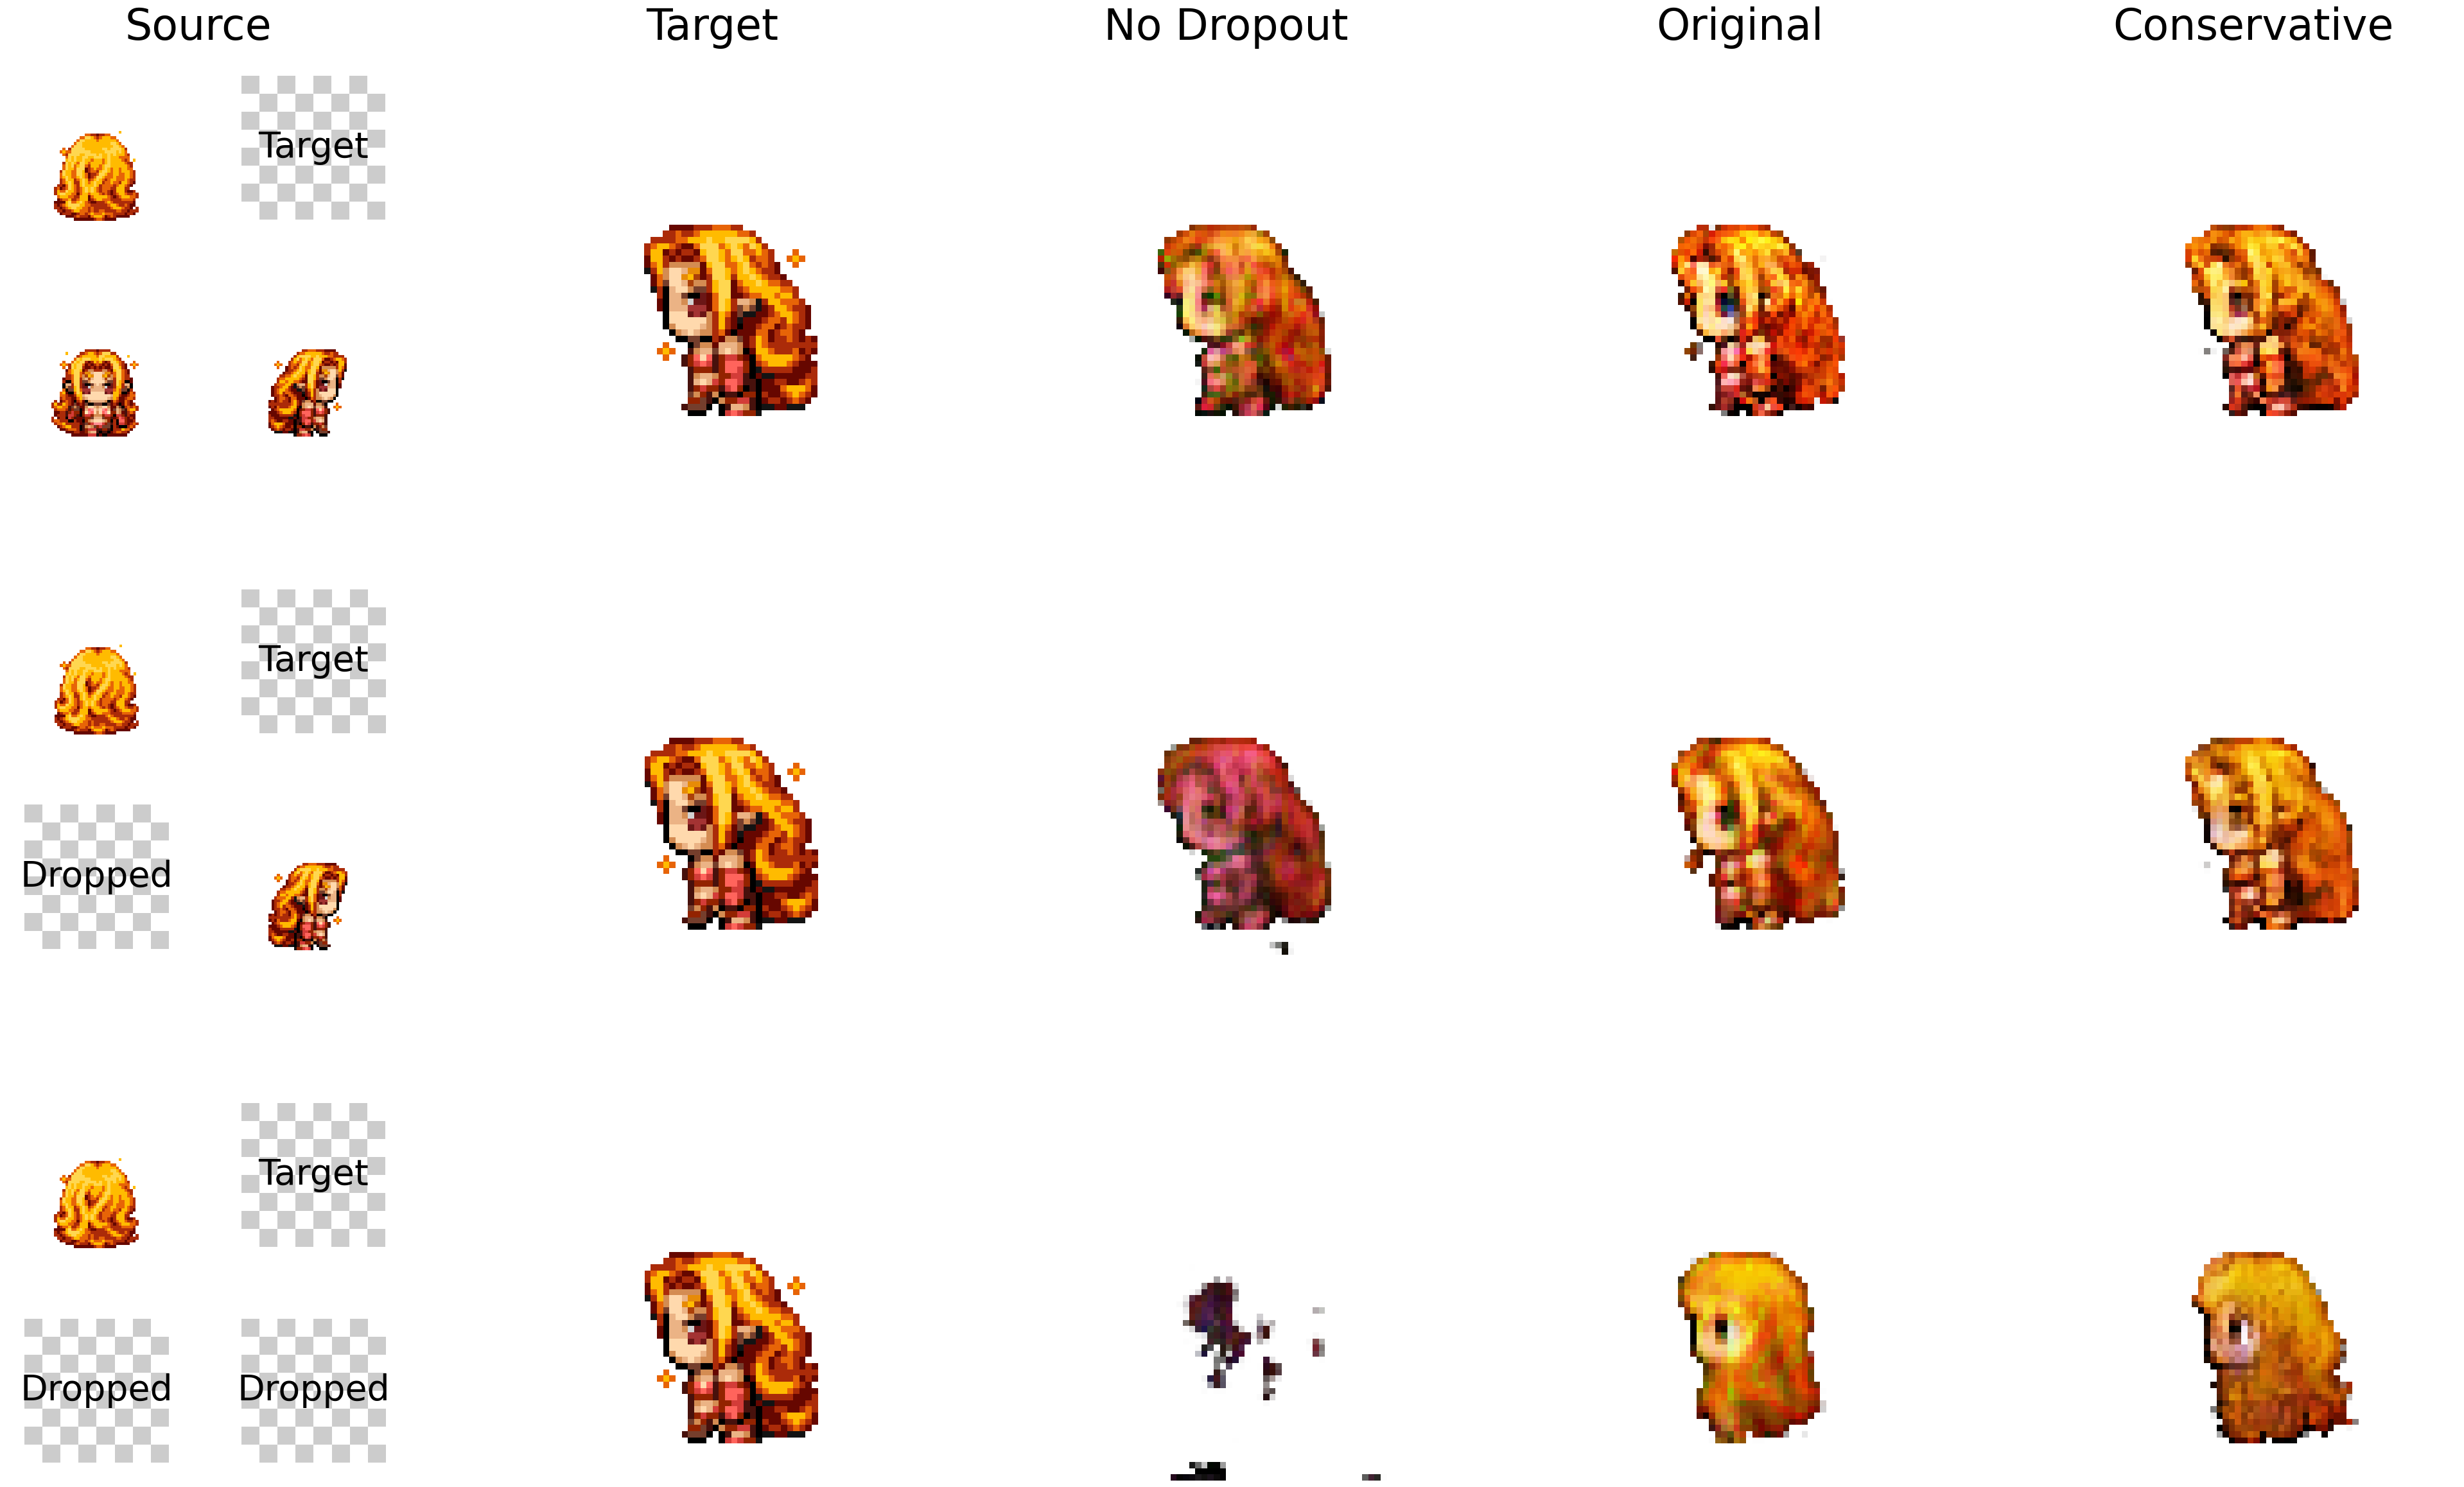

In [4]:
from image_utils import show_multiple_input_model_comparison

f = show_multiple_input_model_comparison(*imgs_params)

## Replacer Image Comparison

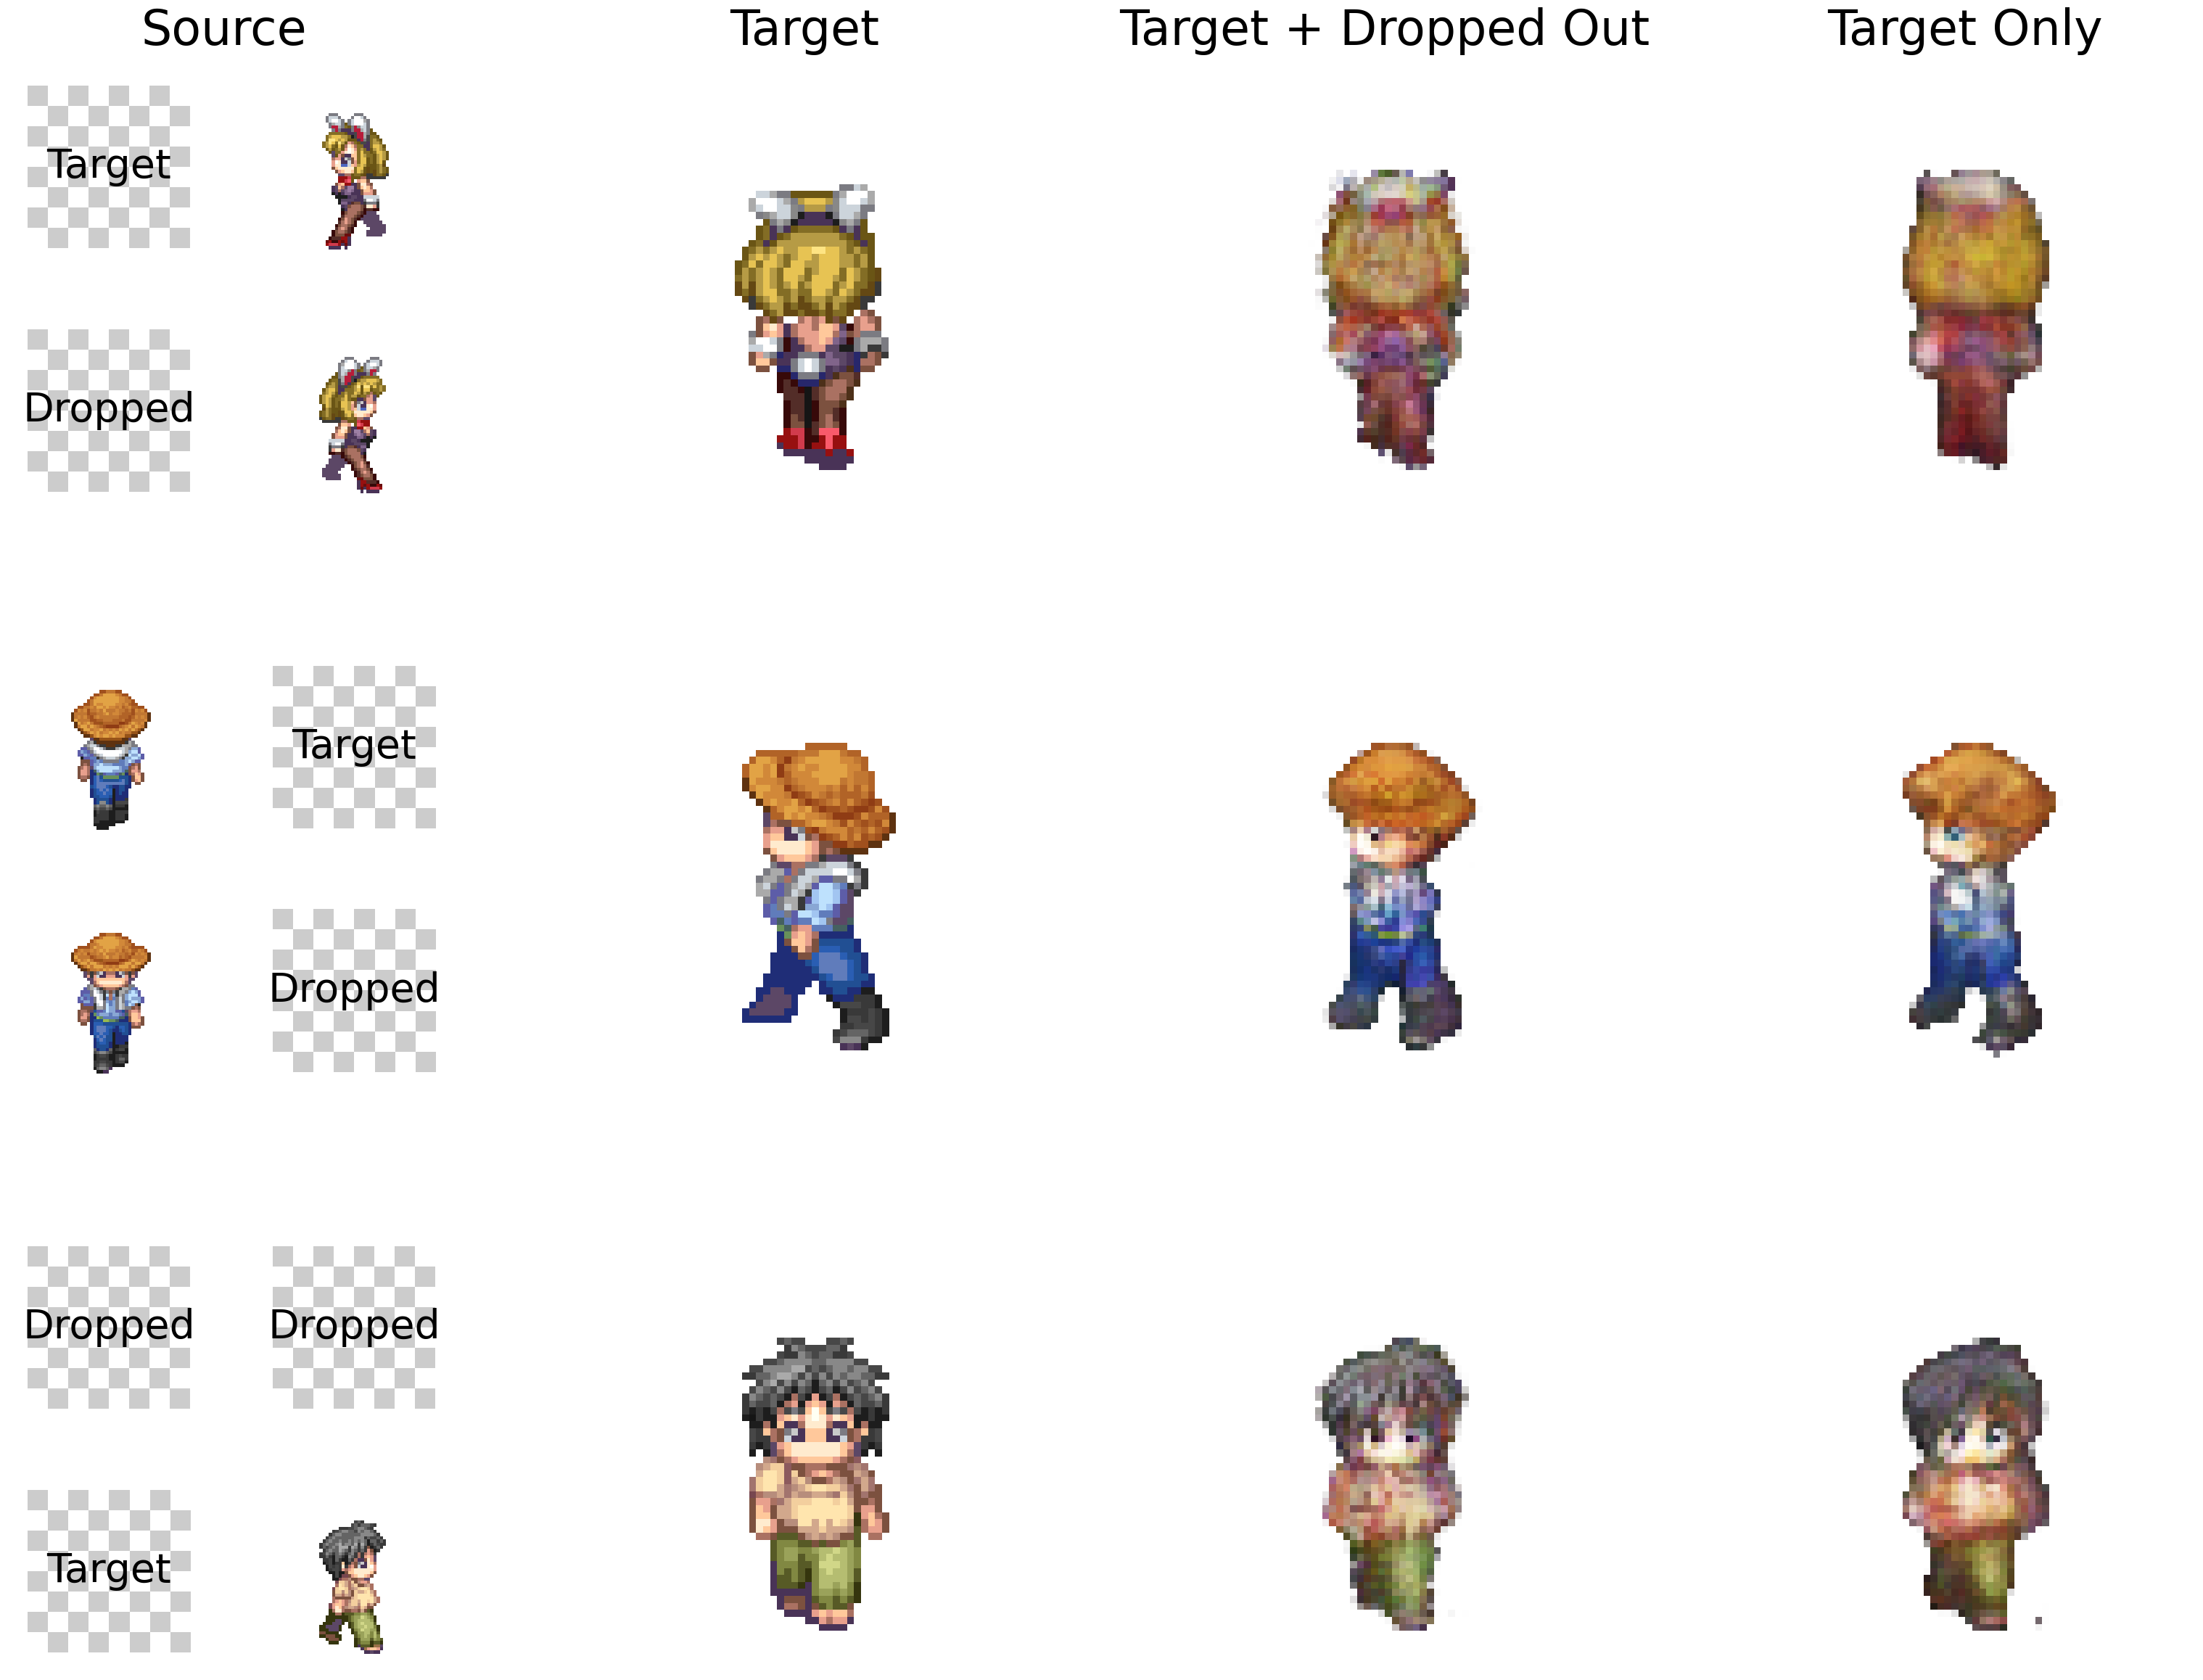

In [5]:
import tensorflow as tf
from image_utils import show_multiple_input_model_comparison

def generate_batch_with_each_model(loaders, sample_numbers, target_indices, should_keep_masks):
    batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
    batch = tf.stack(batch, axis=0)
    
    genned_images = []
    target_indices = tf.constant(target_indices, dtype=tf.int32)
    target_images = tf.gather(batch, target_indices, batch_dims=1)
    should_keep_masks = tf.constant(should_keep_masks,dtype=tf.float32)
    source_images = batch * should_keep_masks[..., tf.newaxis, tf.newaxis, tf.newaxis]
    model_names = list(loaders.keys())
    for _, loader in loaders.items():
        # loads the model into memory
        generator = loader()    
        # generates the images
        fake_images = generator.generate_from_multiple(target_indices, source_images)
        genned_images += [fake_images]
        # frees the memory used by the model
        del generator

    return source_images, target_images, genned_images, "", model_names, target_indices


example_numbers=[
    stsn["rmxp"]+4,     # rmxp bunny tiara girl 
    stsn["rmxp"]+20,    # rmxp maid lady
    stsn["rmxp"]+28,     # rmxp cook
    # stsn["misc"]+779,   # misc suitman                
    # stsn["misc"]+1701,  # misc tiny butt
    # stsn["rmvx"]+27,    # rmvx santa
    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]
targets = [0, 1, 2, 3] * (len(example_numbers) // 4 + 1)
targets = targets[:len(example_numbers)]
keep_masks = [[0, 1, 0, 1], [1, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0]] * (len(example_numbers) // 4 + 1)
keep_masks = keep_masks[:len(example_numbers)]

imgs_params = generate_batch_with_each_model(replacer_model_loaders, example_numbers, targets, keep_masks)
f = show_multiple_input_model_comparison(*imgs_params)



## Generating a base for a Teaser Image

Inspired by the teaser of CollaGAN, we generate an image that translates a single character to all targets from the complete sources.


In [6]:
import tensorflow as tf

def generate_all_targets_each_row(model_loader, sample_numbers):
    batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
    batch = tf.stack(batch, axis=0)
    # print("batch.shape", batch.shape)
    
    target_indices = tf.reshape(tf.tile(tf.constant(tf.range(4), dtype=tf.int32), [len(sample_numbers)]), [len(sample_numbers), 4])
    # print("target_indices.shape", target_indices.shape)
    should_keep_mask = tf.one_hot(target_indices, 4, on_value=0., off_value=1., dtype=tf.float32)
    # print("should_keep_mask", should_keep_mask)
    # print("should_keep_mask.shape", should_keep_mask.shape)
    source_images = batch * should_keep_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
    # loads the model into memory
    generator = model_loader()    
    # generates the images
    target_indices = tf.reshape(target_indices, [-1, 1])
    source_images = tf.reshape(source_images, [-1, 4, 64, 64, 4])
    genned_images = generator.generate_from_multiple(target_indices, source_images)
    genned_images = tf.reshape(genned_images, [len(sample_numbers), 4, 64, 64, 4])
    # frees the memory used by the model
    del generator
    
    return batch, genned_images

example_numbers=[
    stsn["rmxp"]+12,     # rmxp dancer
    # stsn["rmxp"]+4,     # rmxp bunny tiara girl 
    # stsn["rmxp"]+20,    # rmxp maid lady
    # stsn["rmxp"]+28,     # rmxp cook
    # stsn["misc"]+779,   # misc suitman                
    # stsn["misc"]+1701,  # misc tiny butt
    # stsn["rmvx"]+27,    # rmvx santa
    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]

imgs_params = generate_all_targets_each_row(dropout_model_loaders["Conservative"], example_numbers)

2024-05-30 16:50:40 WARNING  5 out of the last 5 calls to <function DatasetLoader.load_paired_images at 0x000002B8023961F8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


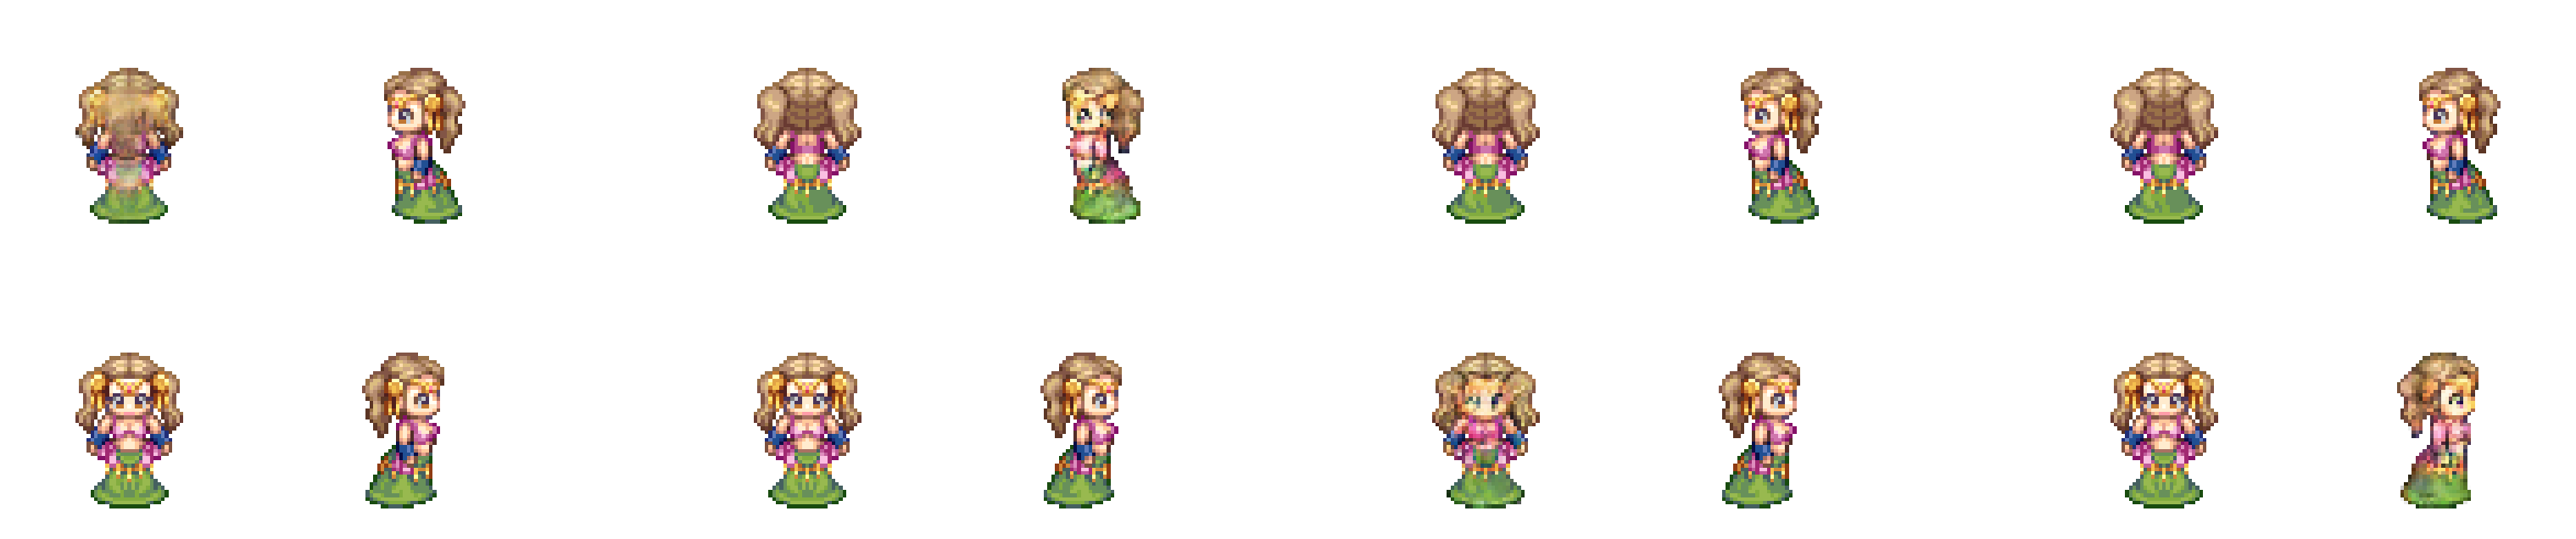

In [7]:
from matplotlib import pyplot as plt

def generate_teaser_image(batch_transpose, genned_images):
    # batch_transpose is (b, d, s, s, c)
    # genned_images is (b, d, s, s, c)
    batch_transpose = batch_transpose * 0.5 + 0.5
    genned_images = genned_images * 0.5 + 0.5
    
    domains = 4
    half_domains = domains // 2
    rows = batch_transpose.shape[0]
    cols = domains
    
    fig = plt.figure(figsize=(8 * cols, 8 * rows))
    sub_figs = fig.subfigures(rows, cols, squeeze=False)
    should_show_genned_image_instead = lambda idx_j, idx_i_d, idx_j_d: idx_j == idx_i_d * half_domains + idx_j_d
    for i in range(rows):
        for j in range(cols):
            sub_figs[i, j].patch.set_alpha(0.0)
            axes = sub_figs[i, j].subplots(half_domains, half_domains, squeeze=False)
            for i_d in range(half_domains):
                for j_d in range(half_domains):
                    ax = axes[i_d, j_d]
                    if should_show_genned_image_instead(j, i_d, j_d):
                        image_source = genned_images
                    else:
                        image_source = batch_transpose
                    ax.imshow(image_source[i][i_d*half_domains + j_d], interpolation="nearest")
                    ax.axis("off")
    

    fig.patch.set_alpha(0.0)
    plt.savefig("output/teaser-base.png", format="png", transparent=True)
    return fig

f = generate_teaser_image(*imgs_params)